# Isomorphic Augmentation Experiment

In this notebook we want to test the hypothesis that most of the performance gains in the SimCLR framework come from the inductive bias of the Convolutional Neural Networks.

We will train the Resnet50 image encoder on the CIFAR10 dataset in the following setups:

1. Use the SimCLR framework with InfoNCE (NT-Xent) without the projection head and no changes to the data $f(x)$
2. Use the SimCLR framewok without the projection head and do an arbitrary permutation to the pixel's positions in the image before training. So our encoder during training will become $f(Permute(x))$

The goal is to compare the performance of these transformations based on:

- InfoNCE loss (The encoders are trained on 400 epochs with a batch of 120)
- Linear probing (Each in the respective domain (after information-preserving mapping)) - linear probes are trained for 50 epochs with a batch of 120
- K-means scoring

### Loading the encoder

The following cell loads the encoder trained for 400 epochs using InfoNCE loss, CIFAR10 dataset and SimCLR framework. You can also see the training losses per batch and per epoch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


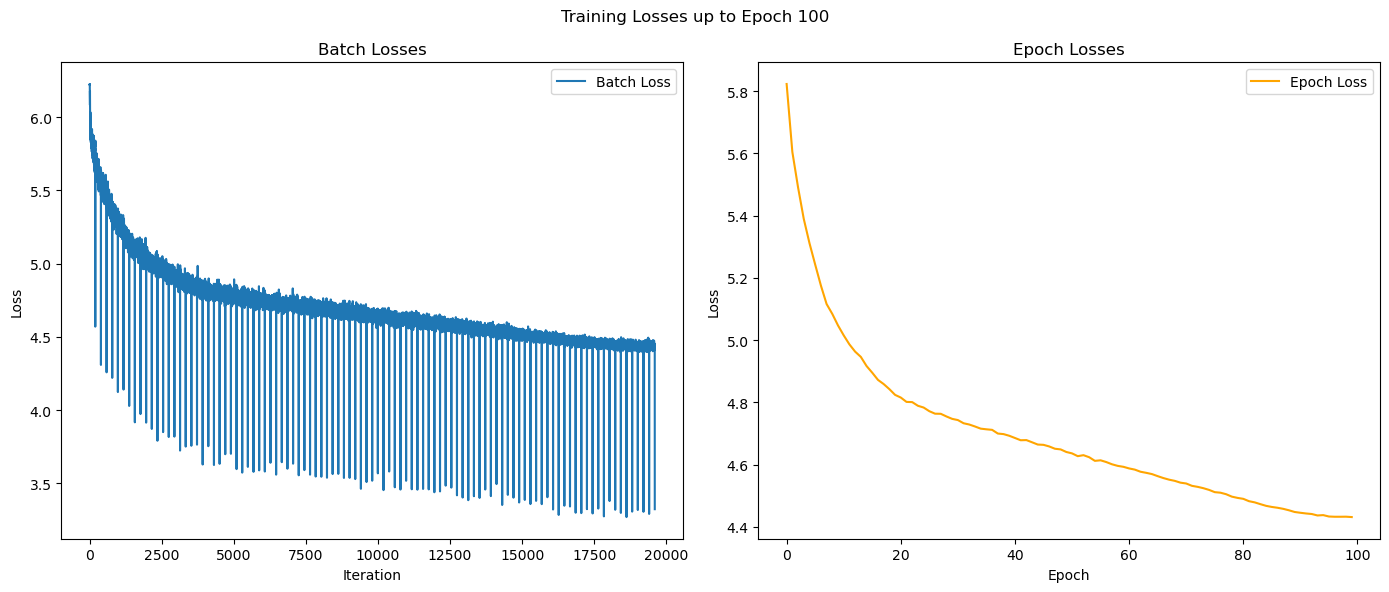

In [9]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt

# Load the checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet-50 encoder (remove the final fc layer for feature extraction)
base_encoder = models.resnet50(weights=None)
base_encoder.fc = nn.Identity()  # remove classification head
checkpoint_path = './checkpoints_isomorphic_training_id_cifar10_sgd_run2/encoder_epoch_100.pt'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

base_encoder.load_state_dict(checkpoint['encoder_state'])
base_encoder = base_encoder.to(device)
base_encoder.eval()

# Retrieve the training losses from the checkpoint
batch_losses = checkpoint.get('losses', [])
epoch_losses = checkpoint.get('epoch_losses', [])
final_epoch = checkpoint.get('epoch', 'Unknown')

# Plot the losses
plt.figure(figsize=(14, 6))

# Plot batch losses
plt.subplot(1, 2, 1)
plt.plot(batch_losses, label='Batch Loss')
plt.title('Batch Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# Plot epoch losses
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Epoch Loss', color='orange')
plt.title('Epoch Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle(f"Training Losses up to Epoch {final_epoch}")
plt.tight_layout()
plt.show()

## Loading the dataset

Here we load the CIFAR10 dataset to examine the data samples

Files already downloaded and verified


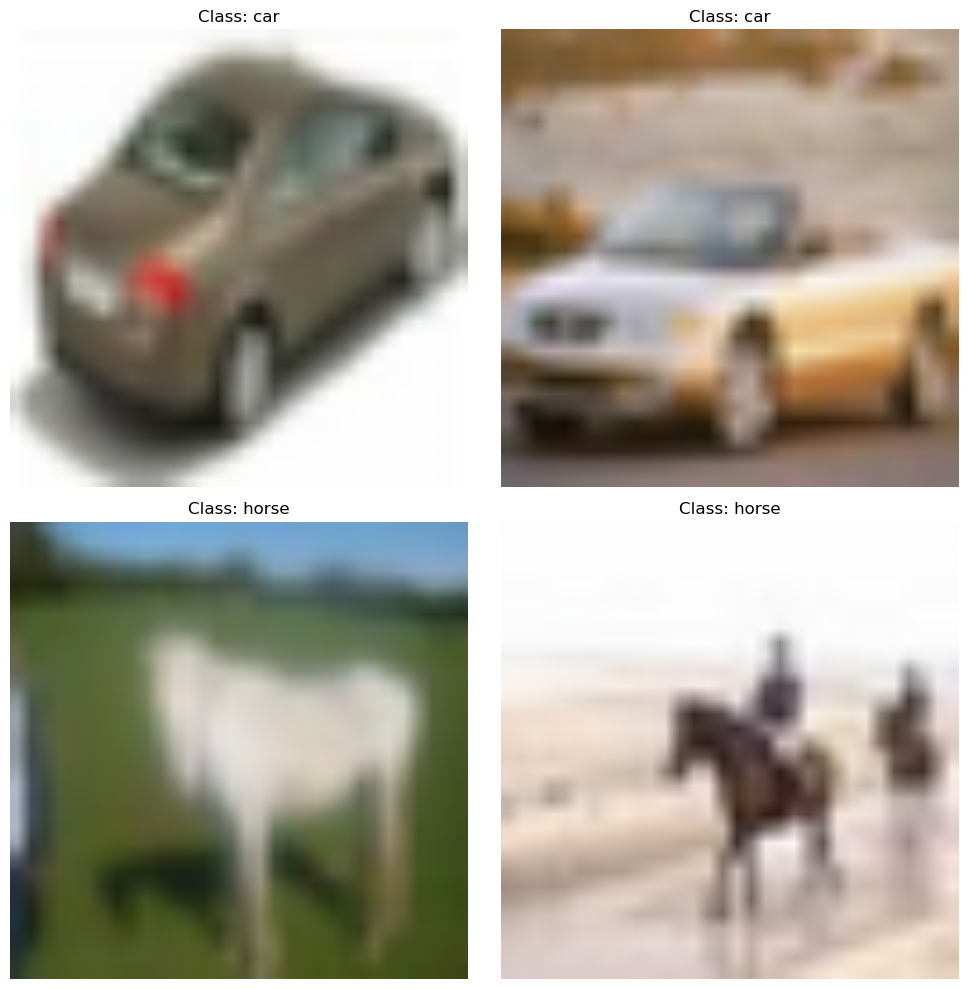

In [10]:
from torchvision import transforms
from data.cifar10 import load_cifar_10

import matplotlib.pyplot as plt
import numpy as np


batch_size = 100

# Transformation: resize + convert to tensor
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
    transforms.ToTensor()
])

train_loader = load_cifar_10(transforms=basic_transform, batch_size=batch_size)['train']

# Function to convert tensor to numpy image
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # C x H x W -> H x W x C
    return img

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def visualize_images(plt, images):
    # Create a figure to display images
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(4):
        img = imshow(images[i])
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {classes[labels[i]]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(plt, images)

Evaluating the resnet50 encoder trained without image permutations by linear probing

In [11]:
from evals.linear_probing import LinearProbeEvaluator

data = load_cifar_10(transforms=basic_transform, batch_size=256, split_validation=False, add_test=True)

train_data_loader = data['train']
test_data_loader = data['test']

# encoder, embedding_dim, num_classes
probe = LinearProbeEvaluator(base_encoder, 2048, 10, device=device)
probe.train(train_data_loader, test_data_loader, epochs=40)

probe.evaluate(test_data_loader)

Files already downloaded and verified
Files already downloaded and verified
Starting linear probe training...


Epoch 1/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:28<00:00,  6.78it/s, loss=1.8023, acc=72.81%]

Epoch 1: Loss = 2.0246, Accuracy = 72.81%
Starting the linear probe evaluation...


[Validation] Accuracy: 75.28%


Epoch 2/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.71it/s, loss=1.4069, acc=76.42%]

Epoch 2: Loss = 1.5724, Accuracy = 76.42%
Starting the linear probe evaluation...


[Validation] Accuracy: 75.41%


Epoch 3/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.64it/s, loss=1.1561, acc=76.56%]

Epoch 3: Loss = 1.2717, Accuracy = 76.56%
Starting the linear probe evaluation...


[Validation] Accuracy: 75.34%


Epoch 4/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.67it/s, loss=0.9414, acc=76.80%]

Epoch 4: Loss = 1.0815, Accuracy = 76.80%
Starting the linear probe evaluation...


[Validation] Accuracy: 75.77%


Epoch 5/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.65it/s, loss=0.7870, acc=76.93%]

Epoch 5: Loss = 0.9602, Accuracy = 76.93%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.07%


Epoch 6/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.64it/s, loss=0.7763, acc=77.10%]

Epoch 6: Loss = 0.8812, Accuracy = 77.10%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.23%


Epoch 7/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.67it/s, loss=0.7724, acc=77.17%]

Epoch 7: Loss = 0.8277, Accuracy = 77.17%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.43%


Epoch 8/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.62it/s, loss=0.6929, acc=77.27%]

Epoch 8: Loss = 0.7902, Accuracy = 77.27%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.43%


Epoch 9/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.68it/s, loss=0.9003, acc=77.33%]

Epoch 9: Loss = 0.7642, Accuracy = 77.33%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.47%


Epoch 10/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.68it/s, loss=0.6697, acc=77.37%]

Epoch 10: Loss = 0.7437, Accuracy = 77.37%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.53%


Epoch 11/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.68it/s, loss=0.7418, acc=77.40%]

Epoch 11: Loss = 0.7289, Accuracy = 77.40%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.63%


Epoch 12/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.66it/s, loss=0.6346, acc=77.46%]

Epoch 12: Loss = 0.7170, Accuracy = 77.46%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.84%


Epoch 13/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.65it/s, loss=0.5108, acc=77.53%]

Epoch 13: Loss = 0.7074, Accuracy = 77.53%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.70%


Epoch 14/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.65it/s, loss=0.6035, acc=77.53%]

Epoch 14: Loss = 0.7003, Accuracy = 77.53%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.72%


Epoch 15/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.62it/s, loss=0.7075, acc=77.62%]

Epoch 15: Loss = 0.6946, Accuracy = 77.62%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.73%


Epoch 16/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.63it/s, loss=0.7096, acc=77.65%]

Epoch 16: Loss = 0.6895, Accuracy = 77.65%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.81%


Epoch 17/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.63it/s, loss=0.5967, acc=77.68%]

Epoch 17: Loss = 0.6849, Accuracy = 77.68%
Starting the linear probe evaluation...


[Validation] Accuracy: 76.72%


Epoch 18/40:  56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 109/196 [00:16<00:13,  6.56it/s, loss=0.7372, acc=77.49%]


KeyboardInterrupt: 

## Linear probe evaluation on classically trained SimCLR resnet50

Linear probe evaluation on the gave 76.6%. SimCLR achieves the maximum value of 84%, but that's likely due to more advanced training techniques

## Invertible permutations

Now, we will give a few examples of invertible permutations applied to images and reversed back

Files already downloaded and verified


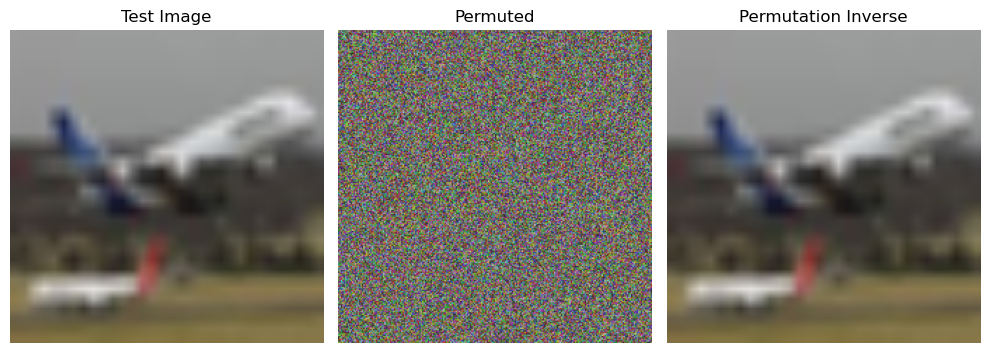

In [6]:
from transformations.image_permutations import ImagePermutationTransform

data = load_cifar_10(transforms=basic_transform, batch_size=1)['train']

images, labels = next(iter(data))
test_image = images[0]

perm_transform = ImagePermutationTransform(test_image.shape[-2], test_image.shape[-1])
img_permuted = perm_transform(test_image.unsqueeze(0))
un_permuted_img = perm_transform.inverse(img_permuted)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(imshow(test_image))
axes[0].set_title(f'Test Image')
axes[0].axis('off')

axes[1].imshow(imshow(img_permuted.squeeze(0)))
axes[1].set_title(f'Permuted')
axes[1].axis('off')

axes[2].imshow(imshow(un_permuted_img.squeeze(0)))
axes[2].set_title(f'Permutation Inverse')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Training the resnet50 encoder using SimCLR aftter data permutations


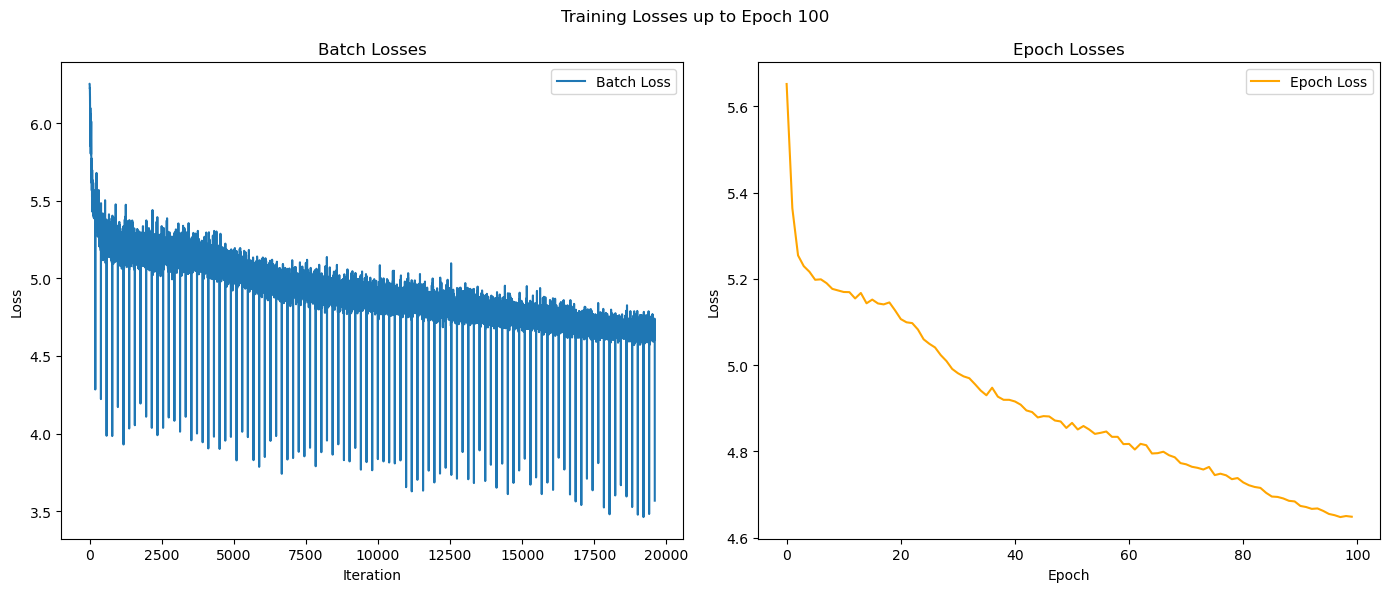

In [7]:
# Initialize the ResNet-50 encoder (remove the final fc layer for feature extraction)
permuted_encoder = models.resnet50(weights=None)
permuted_encoder.fc = nn.Identity()  # remove classification head
checkpoint_path = './checkpoints_isomorphic_training_permutation_cifar10_sgd_run1/encoder_epoch_100.pt'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

permuted_encoder.load_state_dict(checkpoint['encoder_state'])
permuted_encoder = permuted_encoder.to(device)
permuted_encoder.eval()

# Retrieve the training losses from the checkpoint
batch_losses = checkpoint.get('losses', [])
epoch_losses = checkpoint.get('epoch_losses', [])
final_epoch = checkpoint.get('epoch', 'Unknown')

# Plot the losses
plt.figure(figsize=(14, 6))

# Plot batch losses
plt.subplot(1, 2, 1)
plt.plot(batch_losses, label='Batch Loss')
plt.title('Batch Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# Plot epoch losses
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Epoch Loss', color='orange')
plt.title('Epoch Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle(f"Training Losses up to Epoch {final_epoch}")
plt.tight_layout()
plt.show()

## Evaluating the encoder trained on permuted images

1. Use Linear Probe and a normal dataset
2. Use Linear Probe and a permuted dataset

In [8]:
from evals.linear_probing import LinearProbeEvaluator
from data.cifar10 import load_cifar_10

data = load_cifar_10(transforms=basic_transform, batch_size=256, split_validation=False, add_test=True)

train_data_loader = data['train']
test_data_loader = data['test']

# encoder, embedding_dim, num_classes
probe = LinearProbeEvaluator(permuted_encoder, 2048, 10, device=device)
probe.train(train_data_loader, test_data_loader, epochs=40)

probe.evaluate(test_data_loader)

Files already downloaded and verified
Files already downloaded and verified
Starting linear probe training...


Epoch 1/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:28<00:00,  6.81it/s, loss=2.0394, acc=21.86%]

Epoch 1: Loss = 2.0948, Accuracy = 21.86%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.41%


Epoch 2/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:28<00:00,  6.77it/s, loss=2.0165, acc=23.71%]

Epoch 2: Loss = 2.0370, Accuracy = 23.71%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.94%


Epoch 3/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=2.0781, acc=24.46%]

Epoch 3: Loss = 2.0266, Accuracy = 24.46%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.85%


Epoch 4/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.74it/s, loss=2.0524, acc=25.01%]

Epoch 4: Loss = 2.0204, Accuracy = 25.01%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.99%


Epoch 5/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:28<00:00,  6.77it/s, loss=1.9822, acc=25.28%]

Epoch 5: Loss = 2.0155, Accuracy = 25.28%
Starting the linear probe evaluation...


[Validation] Accuracy: 24.43%


Epoch 6/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=1.9745, acc=25.53%]

Epoch 6: Loss = 2.0118, Accuracy = 25.53%
Starting the linear probe evaluation...


[Validation] Accuracy: 24.37%


Epoch 7/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.69it/s, loss=1.9933, acc=25.76%]

Epoch 7: Loss = 2.0086, Accuracy = 25.76%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.60%


Epoch 8/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.71it/s, loss=1.9454, acc=25.74%]

Epoch 8: Loss = 2.0058, Accuracy = 25.74%
Starting the linear probe evaluation...


[Validation] Accuracy: 24.05%


Epoch 9/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.72it/s, loss=1.9944, acc=25.98%]

Epoch 9: Loss = 2.0034, Accuracy = 25.98%
Starting the linear probe evaluation...


[Validation] Accuracy: 24.03%


Epoch 10/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=1.8945, acc=26.27%]

Epoch 10: Loss = 2.0008, Accuracy = 26.27%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.88%


Epoch 11/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.69it/s, loss=1.8572, acc=26.36%]

Epoch 11: Loss = 1.9987, Accuracy = 26.36%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.28%


Epoch 12/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.72it/s, loss=1.9497, acc=26.34%]

Epoch 12: Loss = 1.9969, Accuracy = 26.34%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.82%


Epoch 13/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=2.1298, acc=26.65%]

Epoch 13: Loss = 1.9958, Accuracy = 26.65%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.30%


Epoch 14/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.70it/s, loss=1.9269, acc=26.57%]

Epoch 14: Loss = 1.9933, Accuracy = 26.57%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.01%


Epoch 15/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.70it/s, loss=2.0818, acc=26.83%]

Epoch 15: Loss = 1.9922, Accuracy = 26.83%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.40%


Epoch 16/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.71it/s, loss=1.8849, acc=26.83%]

Epoch 16: Loss = 1.9898, Accuracy = 26.83%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.92%


Epoch 17/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=1.9442, acc=27.06%]

Epoch 17: Loss = 1.9883, Accuracy = 27.06%
Starting the linear probe evaluation...


[Validation] Accuracy: 23.10%


Epoch 18/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.72it/s, loss=1.8939, acc=26.95%]

Epoch 18: Loss = 1.9867, Accuracy = 26.95%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.60%


Epoch 19/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.70it/s, loss=1.9532, acc=27.16%]

Epoch 19: Loss = 1.9856, Accuracy = 27.16%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.24%


Epoch 20/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.72it/s, loss=1.8734, acc=27.05%]

Epoch 20: Loss = 1.9838, Accuracy = 27.05%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.30%


Epoch 21/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.70it/s, loss=1.9659, acc=27.60%]

Epoch 21: Loss = 1.9825, Accuracy = 27.60%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.38%


Epoch 22/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:28<00:00,  6.76it/s, loss=1.8500, acc=27.45%]

Epoch 22: Loss = 1.9812, Accuracy = 27.45%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.24%


Epoch 23/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.70it/s, loss=2.0521, acc=27.34%]

Epoch 23: Loss = 1.9807, Accuracy = 27.34%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.11%


Epoch 24/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.69it/s, loss=1.9571, acc=27.54%]

Epoch 24: Loss = 1.9787, Accuracy = 27.54%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.46%


Epoch 25/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.71it/s, loss=2.0314, acc=27.70%]

Epoch 25: Loss = 1.9777, Accuracy = 27.70%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.83%


Epoch 26/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.74it/s, loss=2.0271, acc=27.82%]

Epoch 26: Loss = 1.9767, Accuracy = 27.82%
Starting the linear probe evaluation...


[Validation] Accuracy: 22.33%


Epoch 27/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.72it/s, loss=2.0929, acc=27.77%]

Epoch 27: Loss = 1.9758, Accuracy = 27.77%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.44%


Epoch 28/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.70it/s, loss=2.0991, acc=27.85%]

Epoch 28: Loss = 1.9748, Accuracy = 27.85%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.38%


Epoch 29/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.71it/s, loss=1.9825, acc=27.93%]

Epoch 29: Loss = 1.9731, Accuracy = 27.93%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.78%


Epoch 30/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.68it/s, loss=2.0408, acc=27.87%]

Epoch 30: Loss = 1.9723, Accuracy = 27.87%
Starting the linear probe evaluation...


[Validation] Accuracy: 20.96%


Epoch 31/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=1.9318, acc=27.96%]

Epoch 31: Loss = 1.9708, Accuracy = 27.96%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.16%


Epoch 32/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.69it/s, loss=2.0180, acc=28.24%]

Epoch 32: Loss = 1.9702, Accuracy = 28.24%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.05%


Epoch 33/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.70it/s, loss=1.8767, acc=28.28%]

Epoch 33: Loss = 1.9686, Accuracy = 28.28%
Starting the linear probe evaluation...


[Validation] Accuracy: 20.72%


Epoch 34/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.69it/s, loss=1.8234, acc=28.17%]

Epoch 34: Loss = 1.9674, Accuracy = 28.17%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.14%


Epoch 35/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.69it/s, loss=1.9931, acc=28.31%]

Epoch 35: Loss = 1.9674, Accuracy = 28.31%
Starting the linear probe evaluation...


[Validation] Accuracy: 21.03%


Epoch 36/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.71it/s, loss=1.9288, acc=28.37%]

Epoch 36: Loss = 1.9659, Accuracy = 28.37%
Starting the linear probe evaluation...


[Validation] Accuracy: 20.46%


Epoch 37/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=2.1168, acc=28.50%]

Epoch 37: Loss = 1.9657, Accuracy = 28.50%
Starting the linear probe evaluation...


[Validation] Accuracy: 19.95%


Epoch 38/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.69it/s, loss=2.0892, acc=28.39%]

Epoch 38: Loss = 1.9648, Accuracy = 28.39%
Starting the linear probe evaluation...


[Validation] Accuracy: 20.59%


Epoch 39/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.72it/s, loss=2.0501, acc=28.46%]

Epoch 39: Loss = 1.9635, Accuracy = 28.46%
Starting the linear probe evaluation...


[Validation] Accuracy: 20.40%


Epoch 40/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.73it/s, loss=1.9032, acc=28.53%]

Epoch 40: Loss = 1.9622, Accuracy = 28.53%
Starting the linear probe evaluation...


[Validation] Accuracy: 19.56%
Starting the linear probe evaluation...
[Validation] Accuracy: 19.56%


19.56

Evaluation without image permutations at most yields 24.43%

In [8]:
from transformations.image_permutations import ImagePermutationTransform
from image_transforms.image_loader_transform import LoaderTransformImagePermutation
from evals.linear_probing import LinearProbeEvaluator

import pickle

transform_path = './saved_transforms/image_permutation.pkl'

# Load the permutation transform from file
with open('./saved_transforms/image_permutation.pkl', 'rb') as f:
    loaded_perm_transform = pickle.load(f)

# Transformation: resize + convert to tensor + perform a random image permutation
permuted_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    LoaderTransformImagePermutation(loaded_perm_transform)
])

data = load_cifar_10(transforms=permuted_transform, batch_size=256, split_validation=False, add_test=True)

train_data_loader = data['train']
test_data_loader = data['test']

# encoder, embedding_dim, num_classes
probe = LinearProbeEvaluator(permuted_encoder, 2048, 10, device=device)
probe.train(train_data_loader, test_data_loader, epochs=40)

probe.evaluate(test_data_loader)

Files already downloaded and verified
Files already downloaded and verified
Starting linear probe training...


Epoch 1/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:28<00:00,  6.76it/s, loss=2.0628, acc=24.25%]

Epoch 1: Loss = 2.1374, Accuracy = 24.25%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.11%


Epoch 2/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.61it/s, loss=1.9617, acc=25.71%]

Epoch 2: Loss = 2.0222, Accuracy = 25.71%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.02%


Epoch 3/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.59it/s, loss=1.9573, acc=25.87%]

Epoch 3: Loss = 1.9958, Accuracy = 25.87%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.19%


Epoch 4/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.57it/s, loss=2.0628, acc=26.02%]

Epoch 4: Loss = 1.9862, Accuracy = 26.02%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.31%


Epoch 5/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.58it/s, loss=1.9913, acc=26.07%]

Epoch 5: Loss = 1.9809, Accuracy = 26.07%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.27%


Epoch 6/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=1.8348, acc=26.20%]

Epoch 6: Loss = 1.9774, Accuracy = 26.20%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.41%


Epoch 7/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.55it/s, loss=1.9796, acc=26.17%]

Epoch 7: Loss = 1.9758, Accuracy = 26.17%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.15%


Epoch 8/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.52it/s, loss=1.9339, acc=26.26%]

Epoch 8: Loss = 1.9741, Accuracy = 26.26%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.23%


Epoch 9/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.51it/s, loss=2.0037, acc=26.13%]

Epoch 9: Loss = 1.9732, Accuracy = 26.13%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.23%


Epoch 10/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=1.8881, acc=26.32%]

Epoch 10: Loss = 1.9720, Accuracy = 26.32%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.43%


Epoch 11/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=2.0369, acc=26.28%]

Epoch 11: Loss = 1.9717, Accuracy = 26.28%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.41%


Epoch 12/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.52it/s, loss=1.8790, acc=26.32%]

Epoch 12: Loss = 1.9706, Accuracy = 26.32%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.68%


Epoch 13/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.52it/s, loss=1.9269, acc=26.18%]

Epoch 13: Loss = 1.9701, Accuracy = 26.18%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.54%


Epoch 14/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.56it/s, loss=1.9430, acc=26.22%]

Epoch 14: Loss = 1.9697, Accuracy = 26.22%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.51%


Epoch 15/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.58it/s, loss=1.9363, acc=26.28%]

Epoch 15: Loss = 1.9692, Accuracy = 26.28%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.39%


Epoch 16/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.54it/s, loss=1.9225, acc=26.30%]

Epoch 16: Loss = 1.9687, Accuracy = 26.30%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.31%


Epoch 17/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=2.0520, acc=26.30%]

Epoch 17: Loss = 1.9688, Accuracy = 26.30%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.50%


Epoch 18/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=1.7699, acc=26.32%]

Epoch 18: Loss = 1.9675, Accuracy = 26.32%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.49%


Epoch 19/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=1.8465, acc=26.33%]

Epoch 19: Loss = 1.9675, Accuracy = 26.33%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.40%


Epoch 20/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.51it/s, loss=2.0636, acc=26.36%]

Epoch 20: Loss = 1.9680, Accuracy = 26.36%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.40%


Epoch 21/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.51it/s, loss=2.0455, acc=26.40%]

Epoch 21: Loss = 1.9675, Accuracy = 26.40%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.45%


Epoch 22/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.52it/s, loss=2.0598, acc=26.44%]

Epoch 22: Loss = 1.9673, Accuracy = 26.44%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.53%


Epoch 23/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.55it/s, loss=1.9853, acc=26.41%]

Epoch 23: Loss = 1.9668, Accuracy = 26.41%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.63%


Epoch 24/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.55it/s, loss=1.9974, acc=26.42%]

Epoch 24: Loss = 1.9667, Accuracy = 26.42%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.45%


Epoch 25/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.54it/s, loss=1.8010, acc=26.42%]

Epoch 25: Loss = 1.9657, Accuracy = 26.42%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.52%


Epoch 26/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.54it/s, loss=1.9351, acc=26.35%]

Epoch 26: Loss = 1.9660, Accuracy = 26.35%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.67%


Epoch 27/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.51it/s, loss=1.9794, acc=26.47%]

Epoch 27: Loss = 1.9660, Accuracy = 26.47%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.41%


Epoch 28/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.58it/s, loss=1.9415, acc=26.51%]

Epoch 28: Loss = 1.9656, Accuracy = 26.51%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.57%


Epoch 29/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.56it/s, loss=1.9975, acc=26.38%]

Epoch 29: Loss = 1.9657, Accuracy = 26.38%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.65%


Epoch 30/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.51it/s, loss=2.0392, acc=26.53%]

Epoch 30: Loss = 1.9656, Accuracy = 26.53%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.70%


Epoch 31/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=1.9535, acc=26.52%]

Epoch 31: Loss = 1.9651, Accuracy = 26.52%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.58%


Epoch 32/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.51it/s, loss=1.8861, acc=26.48%]

Epoch 32: Loss = 1.9647, Accuracy = 26.48%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.70%


Epoch 33/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.56it/s, loss=1.9599, acc=26.48%]

Epoch 33: Loss = 1.9649, Accuracy = 26.48%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.70%


Epoch 34/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.54it/s, loss=1.9122, acc=26.53%]

Epoch 34: Loss = 1.9645, Accuracy = 26.53%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.52%


Epoch 35/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.52it/s, loss=1.9877, acc=26.49%]

Epoch 35: Loss = 1.9646, Accuracy = 26.49%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.71%


Epoch 36/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.55it/s, loss=2.0030, acc=26.48%]

Epoch 36: Loss = 1.9645, Accuracy = 26.48%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.53%


Epoch 37/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.52it/s, loss=1.9526, acc=26.51%]

Epoch 37: Loss = 1.9641, Accuracy = 26.51%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.53%


Epoch 38/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.55it/s, loss=1.9076, acc=26.60%]

Epoch 38: Loss = 1.9639, Accuracy = 26.60%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.51%


Epoch 39/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:29<00:00,  6.55it/s, loss=1.9199, acc=26.56%]

Epoch 39: Loss = 1.9638, Accuracy = 26.56%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.42%


Epoch 40/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:30<00:00,  6.53it/s, loss=1.8185, acc=26.49%]

Epoch 40: Loss = 1.9632, Accuracy = 26.49%
Starting the linear probe evaluation...


[Validation] Accuracy: 26.54%
Starting the linear probe evaluation...
[Validation] Accuracy: 26.54%


26.540000000000003

With image permutation accuracy, the validation accuracy gives 26.54 %